In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
import multiprocessing

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Lectura de datos
df0 = pd.read_csv('salidas/base_RF.csv')
df = df0[df0.columns[1:]]
df.columns

C:\Users\daago\AppData\Local\Temp\ipykernel_3224\2951722974.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv('salidas/base_RF.csv')


Index(['y', 'x', 'Localidad', 'Estacion', 'year', 'month', 'pm10', 'pm25',
       'o3', 'co', 't2', 'ws', 'wd', 'rn', 'Codigo localidad', 'MuertesxPM25',
       'Poblacion'],
      dtype='object')

In [3]:
# Seleccionar registros con todos los datos de pm25: Con esto se va construir el modelo
df_clean = df.dropna(subset= ['pm25']).copy()
df_clean = df_clean[df_clean["pm25"] < 100]
df_clean

,y,x,Localidad,Estacion,year,month,pm10,pm25,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion
8,10,8,Barrios Unidos,CDAR,2008,9,41.720645,15.467811,12.239741,0.766667,14.322961,NaN,215.839056,0.022961,12,5.0,178732
9,10,8,Barrios Unidos,CDAR,2008,10,31.215385,10.073333,12.813333,0.633333,14.566667,0.300000,159.400000,0.033333,12,8.0,178732
13,10,8,Barrios Unidos,CDAR,2009,2,50.963208,15.219159,17.169811,0.998131,14.525943,1.541038,227.551887,0.261321,12,16.0,169541
14,10,8,Barrios Unidos,CDAR,2009,3,50.861248,20.300000,12.689455,1.087201,14.427994,1.499134,226.017316,0.208802,12,10.0,169541
15,10,8,Barrios Unidos,CDAR,2009,4,42.662035,15.753422,11.274026,0.875166,15.048859,1.673954,212.596958,0.119962,12,118.0,169541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,7,11,Usaquén,Usaquen,2020,11,18.366778,13.017282,12.283013,0.642984,14.175037,0.963811,158.591654,0.366617,1,190.0,564539
2075,7,11,Usaquén,Usaquen,2020,12,13.312155,7.903863,15.479627,0.437590,14.656509,1.380401,146.329041,0.111302,1,124.0,564539
2076,7,11,Usaquén,Usaquen,2021,1,13.796472,7.430504,15.285281,0.467194,14.077698,1.359856,138.979856,0.008489,1,106.0,571268
2077,7,11,Usaquén,Usaquen,2021,2,14.773455,8.487687,14.779167,0.428619,14.811814,1.418802,151.698835,0.082196,1,38.0,571268


In [4]:
df_clean.columns

Index(['y', 'x', 'Localidad', 'Estacion', 'year', 'month', 'pm10', 'pm25',
       'o3', 'co', 't2', 'ws', 'wd', 'rn', 'Codigo localidad', 'MuertesxPM25',
       'Poblacion'],
      dtype='object')

In [5]:
df1 = df_clean[['y', 'x', 'year', 'month',  'pm10', 'pm25',
       'o3', 'co', 't2', 'ws', 'wd', 'rn', 'Codigo localidad', 'MuertesxPM25', 'Poblacion']].copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 8 to 2078
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   y                 1294 non-null   int64  
 1   x                 1294 non-null   int64  
 2   year              1294 non-null   int64  
 3   month             1294 non-null   int64  
 4   pm10              1278 non-null   float64
 5   pm25              1294 non-null   float64
 6   o3                1138 non-null   float64
 7   co                887 non-null    float64
 8   t2                1134 non-null   float64
 9   ws                1260 non-null   float64
 10  wd                1267 non-null   float64
 11  rn                1236 non-null   float64
 12  Codigo localidad  1294 non-null   int64  
 13  MuertesxPM25      1293 non-null   float64
 14  Poblacion         1294 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 161.8 KB


In [6]:
# Imputar los datos de las variables restantes con Miss Forest
import sklearn.neighbors._base 
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

imputer = MissForest() #miss forest
X_imputed = imputer.fit_transform(df1)
X_imputed = pd.DataFrame(X_imputed, columns = df1.columns).round(3)
X_imputed


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 0


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 1


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 2


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 3


,y,x,year,month,pm10,pm25,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion
0,10.0,8.0,2008.0,9.0,41.721,15.468,12.240,0.767,14.323,0.934,215.839,0.023,12.0,5.0,178732.0
1,10.0,8.0,2008.0,10.0,31.215,10.073,12.813,0.633,14.567,0.300,159.400,0.033,12.0,8.0,178732.0
2,10.0,8.0,2009.0,2.0,50.963,15.219,17.170,0.998,14.526,1.541,227.552,0.261,12.0,16.0,169541.0
3,10.0,8.0,2009.0,3.0,50.861,20.300,12.689,1.087,14.428,1.499,226.017,0.209,12.0,10.0,169541.0
4,10.0,8.0,2009.0,4.0,42.662,15.753,11.274,0.875,15.049,1.674,212.597,0.120,12.0,118.0,169541.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,7.0,11.0,2020.0,11.0,18.367,13.017,12.283,0.643,14.175,0.964,158.592,0.367,1.0,190.0,564539.0
1290,7.0,11.0,2020.0,12.0,13.312,7.904,15.480,0.438,14.657,1.380,146.329,0.111,1.0,124.0,564539.0
1291,7.0,11.0,2021.0,1.0,13.796,7.431,15.285,0.467,14.078,1.360,138.980,0.008,1.0,106.0,571268.0
1292,7.0,11.0,2021.0,2.0,14.773,8.488,14.779,0.429,14.812,1.419,151.699,0.082,1.0,38.0,571268.0


In [7]:
datos = X_imputed.copy()
#datos= df1.dropna().copy()

In [8]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns = "pm25")
y = datos['pm25']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        random_state = 123,
                                        test_size = 0.2
                                    )
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mae',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mae', n_estimators=10, n_jobs=-1,
                      random_state=123)

In [9]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (mae) de test es: {mae}")

El error (mae) de test es: 2.427973359073359


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was d

Valor óptimo de n_estimators: 19


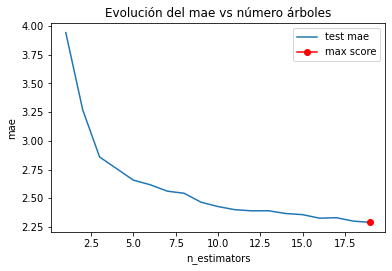

In [10]:
# Validación número de estimadores por mae
# ==============================================================================
test_mae = []

# Valores evaluados
estimator_range = range(1, 20, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mae',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    test_mae.append(mean_absolute_error(y_test, modelo.predict(X_test)))

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, test_mae, label="test mae")

ax.plot(estimator_range[np.argmin(test_mae)], min(test_mae),
        marker='o', color = "red", label="max score")
ax.set_ylabel("mae")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del mae vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(test_mae)]}")

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

Valor óptimo de n_estimators: 19


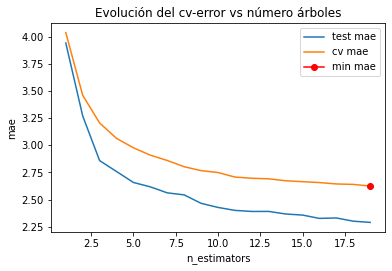

In [11]:
# Validación empleando k-cross-validation
# ==============================================================================
test_mae = []
cv_mae    = []

# Valores evaluados
estimator_range = range(1, 20, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mae',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de test
    modelo.fit(X_train, y_train)
    
    predicciones = modelo.predict(X = X_test)

    mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
    test_mae.append(mae)
    
    
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_mean_absolute_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_mae.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, test_mae, label="test mae")
ax.plot(estimator_range, cv_mae, label="cv mae")
ax.plot(estimator_range[np.argmin(cv_mae)], min(cv_mae),
        marker='o', color = "red", label="min mae")
ax.set_ylabel("mae")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_mae)]}")

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

Valor óptimo de max_features: 10


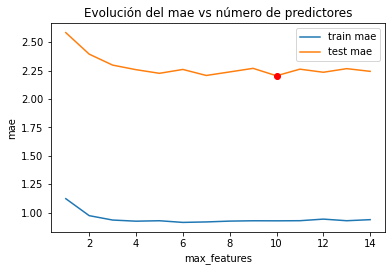

In [12]:
# Validación empleando el test_mae
# ==============================================================================
train_mae = []
test_mae   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de prueba.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mae',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_mae.append(mean_absolute_error(y_train, modelo.predict(X_train)))
    test_mae.append(mean_absolute_error(y_test, modelo.predict(X_test)))
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_mae, label="train mae")
ax.plot(max_features_range, test_mae, label="test mae")
ax.plot(max_features_range[np.argmin(test_mae)], min(test_mae),
        marker='o', color = "red")
ax.set_ylabel("mae")
ax.set_xlabel("max_features")
ax.set_title("Evolución del mae vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(test_mae)]}")

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarnin

Valor óptimo de max_features: 6


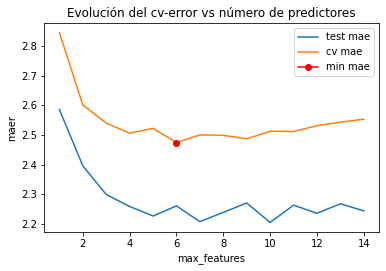

In [13]:
# Validación empleando k-cross-validation 
# ==============================================================================
test_mae = []
cv_mae    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mae',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    
    # Error de test
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_test)
    mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
    test_mae.append(mae)
    
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_mean_absolute_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_mae.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, test_mae, label="test mae")
ax.plot(max_features_range, cv_mae, label="cv mae")
ax.plot(max_features_range[np.argmin(cv_mae)], min(cv_mae),
        marker='o', color = "red", label="min mae")
ax.set_ylabel("maer")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_mae)]}")

In [14]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {#'n_estimators': [10,11,12,13,14,15,16,17],
                'n_estimators': [9,10,11,12,13],
                 'max_features': [4,5,6,7,8],
                 'max_depth'   : [None, 1,2,3,4,5,6,7,8]
                }
             

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_mean_absolute_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
24,None,8,13,-2.629633,0.174551,-1.039071,0.025723
19,None,7,13,-2.633952,0.203748,-1.041529,0.016641
14,None,6,13,-2.640676,0.227273,-1.045128,0.027708
23,None,8,12,-2.644348,0.182824,-1.054067,0.027902


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


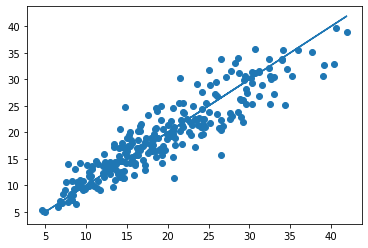

In [15]:
### MODELO INICIAL

modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mae',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test)
plt.show()

In [16]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (mae) de test es: {mae}")
df_fit = pd.DataFrame({'pm25_test': y_test, 'pm25_RF': y_pred})
#df_fit.to_excel('salidas/01-RF1.xlsx',index=False)
X = df_fit[['pm25_RF']]
y = df_fit['pm25_test']
lm = linear_model.LinearRegression()
lm.fit(X.values.reshape(-1,1), y.values.reshape(-1,1))
PM25_pred = lm.predict(X.values.reshape(-1,1))
print("Intercept:", lm.intercept_)
print("Coeficiente:", list(zip(X.columns, lm.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", lm.score(X, y))

El error (mae) de test es: 2.427973359073359
Intercept: [0.49620761]
Coeficiente: [('pm25_RF', 0.983004540582563)]
Coeficiente de determinación R^2: 0.8362424135847324


C:\Users\daago\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [17]:
### MODELO OPTIMIZADO

modelo = RandomForestRegressor(
            n_estimators = 12,
            criterion    = 'mae',
            max_depth    = None,
            max_features = 8,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Error de train
modelo.fit(X_train, y_train)

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mae', max_features=8, n_estimators=12,
                      n_jobs=-1, random_state=123)

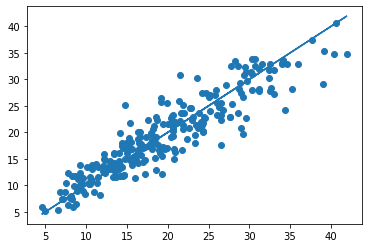

In [18]:
y_pred = modelo.predict(X_test)
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test)
plt.show()

In [19]:
df_fit = pd.DataFrame({'pm25_test': y_test, 'pm25_RF': y_pred})
#df_fit.to_excel('salidas/02-RF1.xlsx',index=False)
X = df_fit[['pm25_RF']]
y = df_fit['pm25_test']

In [20]:

lm = linear_model.LinearRegression()
lm.fit(X.values.reshape(-1,1), y.values.reshape(-1,1))
PM25_pred = lm.predict(X.values.reshape(-1,1))

# Información del modelo
# ==============================================================================
print("Intercept:", lm.intercept_)
print("Coeficiente:", list(zip(X.columns, lm.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", lm.score(X, y))
print("rmse:",mean_squared_error(y,PM25_pred,squared = False))


Intercept: [0.50700836]
Coeficiente: [('pm25_RF', 0.9809957529414179)]
Coeficiente de determinación R^2: 0.8456199866568953
rmse: 3.102088775470942


C:\Users\daago\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [21]:
# Error de test del modelo optimizado
# ==============================================================================
predicciones = modelo.predict(X = X_test)

mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (mae) de test es: {mae}")

El error (mae) de test es: 2.3413986486486484


In [22]:
###### Usar el modelo para los demás 


In [23]:
df_final = df0[['Unnamed: 0','y', 'x', 'year', 'month',  'pm10',
       'o3', 'co', 't2', 'ws', 'wd', 'rn', 'Codigo localidad', 'MuertesxPM25', 'Poblacion']]
df_final

,Unnamed: 0,y,x,year,month,pm10,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion
0,0,10,8,2008,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,168.0,178732
1,1,10,8,2008,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,12.0,178732
2,2,10,8,2008,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,25.0,178732
3,3,10,8,2008,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,35.0,178732
4,4,10,8,2008,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,20.0,178732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,35835,19,9,2020,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,115.0,384943
35836,35836,19,9,2021,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,37.0,393366
35837,35837,19,9,2021,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,23.0,393366
35838,35838,19,9,2021,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,21.0,393366


In [24]:
imputer = MissForest() #miss forest
X_imputed = imputer.fit_transform(df_final)
X_imputed = pd.DataFrame(X_imputed, columns = df_final.columns).round(3)
X_imputed

C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 0


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 1


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 2


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 3


C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\daago\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 4


,Unnamed: 0,y,x,year,month,pm10,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion
0,0.0,10.0,8.0,2008.0,1.0,48.076,16.890,1.063,14.377,0.953,219.130,0.128,12.0,168.0,178732.0
1,1.0,10.0,8.0,2008.0,2.0,50.438,15.426,1.134,14.575,0.989,221.460,0.175,12.0,12.0,178732.0
2,2.0,10.0,8.0,2008.0,3.0,49.711,14.937,1.147,14.575,0.982,221.215,0.177,12.0,25.0,178732.0
3,3.0,10.0,8.0,2008.0,4.0,42.852,12.070,0.961,14.568,0.953,223.071,0.178,12.0,35.0,178732.0
4,4.0,10.0,8.0,2008.0,5.0,41.731,8.750,1.036,14.680,0.965,223.108,0.195,12.0,20.0,178732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,35835.0,19.0,9.0,2020.0,12.0,22.061,12.427,0.620,14.396,1.277,157.840,0.188,5.0,115.0,384943.0
35836,35836.0,19.0,9.0,2021.0,1.0,21.561,14.741,0.667,14.442,1.429,162.370,0.104,5.0,37.0,393366.0
35837,35837.0,19.0,9.0,2021.0,2.0,34.461,14.091,0.751,14.599,1.395,164.883,0.158,5.0,23.0,393366.0
35838,35838.0,19.0,9.0,2021.0,3.0,34.384,13.867,0.775,14.582,1.371,163.511,0.181,5.0,21.0,393366.0


In [25]:
X_final = X_imputed[X_imputed.columns[1:]]
X_imputed['RF'] = modelo.predict(X_final)
X_imputed

,Unnamed: 0,y,x,year,month,pm10,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion,RF
0,0.0,10.0,8.0,2008.0,1.0,48.076,16.890,1.063,14.377,0.953,219.130,0.128,12.0,168.0,178732.0,22.814917
1,1.0,10.0,8.0,2008.0,2.0,50.438,15.426,1.134,14.575,0.989,221.460,0.175,12.0,12.0,178732.0,22.724250
2,2.0,10.0,8.0,2008.0,3.0,49.711,14.937,1.147,14.575,0.982,221.215,0.177,12.0,25.0,178732.0,23.746417
3,3.0,10.0,8.0,2008.0,4.0,42.852,12.070,0.961,14.568,0.953,223.071,0.178,12.0,35.0,178732.0,26.783000
4,4.0,10.0,8.0,2008.0,5.0,41.731,8.750,1.036,14.680,0.965,223.108,0.195,12.0,20.0,178732.0,18.057167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,35835.0,19.0,9.0,2020.0,12.0,22.061,12.427,0.620,14.396,1.277,157.840,0.188,5.0,115.0,384943.0,10.966833
35836,35836.0,19.0,9.0,2021.0,1.0,21.561,14.741,0.667,14.442,1.429,162.370,0.104,5.0,37.0,393366.0,12.081667
35837,35837.0,19.0,9.0,2021.0,2.0,34.461,14.091,0.751,14.599,1.395,164.883,0.158,5.0,23.0,393366.0,17.569583
35838,35838.0,19.0,9.0,2021.0,3.0,34.384,13.867,0.775,14.582,1.371,163.511,0.181,5.0,21.0,393366.0,17.893417


In [26]:
df_final_pm25 = df0[['Unnamed: 0','pm25']]
df_final_pm25

,Unnamed: 0,pm25
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
35835,35835,NaN
35836,35836,NaN
35837,35837,NaN
35838,35838,NaN


In [27]:
df_sol = pd.merge(X_imputed,df0[['Unnamed: 0','pm25']], on = 'Unnamed: 0')
df_sol

,Unnamed: 0,y,x,year,month,pm10,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion,RF,pm25
0,0.0,10.0,8.0,2008.0,1.0,48.076,16.890,1.063,14.377,0.953,219.130,0.128,12.0,168.0,178732.0,22.814917,NaN
1,1.0,10.0,8.0,2008.0,2.0,50.438,15.426,1.134,14.575,0.989,221.460,0.175,12.0,12.0,178732.0,22.724250,NaN
2,2.0,10.0,8.0,2008.0,3.0,49.711,14.937,1.147,14.575,0.982,221.215,0.177,12.0,25.0,178732.0,23.746417,NaN
3,3.0,10.0,8.0,2008.0,4.0,42.852,12.070,0.961,14.568,0.953,223.071,0.178,12.0,35.0,178732.0,26.783000,NaN
4,4.0,10.0,8.0,2008.0,5.0,41.731,8.750,1.036,14.680,0.965,223.108,0.195,12.0,20.0,178732.0,18.057167,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,35835.0,19.0,9.0,2020.0,12.0,22.061,12.427,0.620,14.396,1.277,157.840,0.188,5.0,115.0,384943.0,10.966833,NaN
35836,35836.0,19.0,9.0,2021.0,1.0,21.561,14.741,0.667,14.442,1.429,162.370,0.104,5.0,37.0,393366.0,12.081667,NaN
35837,35837.0,19.0,9.0,2021.0,2.0,34.461,14.091,0.751,14.599,1.395,164.883,0.158,5.0,23.0,393366.0,17.569583,NaN
35838,35838.0,19.0,9.0,2021.0,3.0,34.384,13.867,0.775,14.582,1.371,163.511,0.181,5.0,21.0,393366.0,17.893417,NaN


In [28]:
df_sol1 = df_sol.dropna()
df_sol1 = df_sol1[df_sol1.pm25 <100]

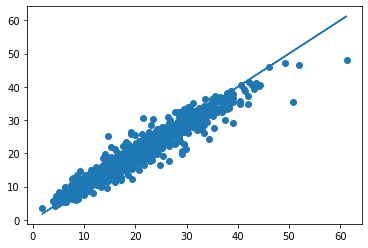

In [29]:
plt.scatter(df_sol1.pm25,df_sol1.RF)
plt.plot(df_sol1.pm25, df_sol1.pm25)
plt.show()

In [30]:
df_sol1

,Unnamed: 0,y,x,year,month,pm10,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion,RF,pm25
8,8.0,10.0,8.0,2008.0,9.0,41.721,12.240,0.767,14.323,0.901,215.839,0.023,12.0,5.0,178732.0,15.354167,15.467811
9,9.0,10.0,8.0,2008.0,10.0,31.215,12.813,0.633,14.567,0.300,159.400,0.033,12.0,8.0,178732.0,11.078000,10.073333
13,13.0,10.0,8.0,2009.0,2.0,50.963,17.170,0.998,14.526,1.541,227.552,0.261,12.0,16.0,169541.0,16.489250,15.219159
14,14.0,10.0,8.0,2009.0,3.0,50.861,12.689,1.087,14.428,1.499,226.017,0.209,12.0,10.0,169541.0,20.492583,20.300000
15,15.0,10.0,8.0,2009.0,4.0,42.662,11.274,0.875,15.049,1.674,212.597,0.120,12.0,118.0,169541.0,17.213417,15.753422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,2074.0,7.0,11.0,2020.0,11.0,18.367,12.283,0.643,14.175,0.964,158.592,0.367,1.0,190.0,564539.0,12.569833,13.017282
2075,2075.0,7.0,11.0,2020.0,12.0,13.312,15.480,0.438,14.657,1.380,146.329,0.111,1.0,124.0,564539.0,7.733083,7.903863
2076,2076.0,7.0,11.0,2021.0,1.0,13.796,15.285,0.467,14.078,1.360,138.980,0.008,1.0,106.0,571268.0,10.570083,7.430504
2077,2077.0,7.0,11.0,2021.0,2.0,14.773,14.779,0.429,14.812,1.419,151.699,0.082,1.0,38.0,571268.0,9.796667,8.487687


In [31]:
df_fit = pd.DataFrame({'pm25_test': df_sol1.pm25, 'pm25_RF': df_sol1.RF})
df_fit.to_excel('salidas/03-RF1.xlsx',index=False)
X = df_fit[['pm25_RF']]
y = df_fit['pm25_test']

In [32]:
lm = linear_model.LinearRegression()
lm.fit(X.values.reshape(-1,1), y.values.reshape(-1,1))
PM25_pred = lm.predict(X.values.reshape(-1,1))

# Información del modelo
# ==============================================================================
print("Intercept:", lm.intercept_)
print("Coeficiente:", list(zip(X.columns, lm.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", lm.score(X, y))
print("rmse:",mean_squared_error(y,PM25_pred,squared = False))


Intercept: [-0.55528617]
Coeficiente: [('pm25_RF', 1.0360693135235868)]
Coeficiente de determinación R^2: 0.943129978986767
rmse: 2.055570569057222


C:\Users\daago\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [33]:
df_sol.to_csv('salidas/Salida_RF.csv',sep=';',index=False)

In [34]:
df_sol

,Unnamed: 0,y,x,year,month,pm10,o3,co,t2,ws,wd,rn,Codigo localidad,MuertesxPM25,Poblacion,RF,pm25
0,0.0,10.0,8.0,2008.0,1.0,48.076,16.890,1.063,14.377,0.953,219.130,0.128,12.0,168.0,178732.0,22.814917,NaN
1,1.0,10.0,8.0,2008.0,2.0,50.438,15.426,1.134,14.575,0.989,221.460,0.175,12.0,12.0,178732.0,22.724250,NaN
2,2.0,10.0,8.0,2008.0,3.0,49.711,14.937,1.147,14.575,0.982,221.215,0.177,12.0,25.0,178732.0,23.746417,NaN
3,3.0,10.0,8.0,2008.0,4.0,42.852,12.070,0.961,14.568,0.953,223.071,0.178,12.0,35.0,178732.0,26.783000,NaN
4,4.0,10.0,8.0,2008.0,5.0,41.731,8.750,1.036,14.680,0.965,223.108,0.195,12.0,20.0,178732.0,18.057167,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,35835.0,19.0,9.0,2020.0,12.0,22.061,12.427,0.620,14.396,1.277,157.840,0.188,5.0,115.0,384943.0,10.966833,NaN
35836,35836.0,19.0,9.0,2021.0,1.0,21.561,14.741,0.667,14.442,1.429,162.370,0.104,5.0,37.0,393366.0,12.081667,NaN
35837,35837.0,19.0,9.0,2021.0,2.0,34.461,14.091,0.751,14.599,1.395,164.883,0.158,5.0,23.0,393366.0,17.569583,NaN
35838,35838.0,19.0,9.0,2021.0,3.0,34.384,13.867,0.775,14.582,1.371,163.511,0.181,5.0,21.0,393366.0,17.893417,NaN
